# Discovery of Writing Differences - Neural Networks Representation

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import plotly.express as px
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import umap
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram

from joblib import dump, load

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1086: 

## Reading In the Library and Prep for NN

In this part, reading the .pkl file. 

In [2]:
library_select = pd.read_pickle('../data/library_select03.pkl')

In [3]:
library_select.shape

(527, 12)

Next, extract authors, create dictionary to convert authors name to numeric values (for predictions) and add a column with that.

In [4]:
select_authors = list(library_select.sort_values(by='authorcentury')['author'].unique())

authors_to_num = {select_authors[i]: i for i in range(len(select_authors))}
#num_to_authors = {v: k for k, v in authors_to_num.items()}

library_select['author_num'] = library_select['author'].map(authors_to_num)

## Sklearn NN

First round of neural network analysis, using sklearn.

In [5]:
X = library_select[['book_content']]
y = library_select['author_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [6]:
library_select.shape

(527, 13)

In [7]:
pipe_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, 100),
                             #activation = 'relu',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [8]:
# pipe_nn.fit(X_train['book_content'], y_train)
# y_pred = pipe_nn.predict(X_test['book_content'])

# print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
# print('----- confusion matrix ------')
# print(confusion_matrix(y_test, y_pred), '\n')
# print('-------- classification report ---------')
# print(classification_report(y_test, y_pred))

# this below ran for almost 2 hours and didn't finish yet...
pipe_nn.fit(X['book_content'], y)
y_pred = pipe_nn.predict(X['book_content'])

print('accuracy score:', accuracy_score(y, y_pred), '\n')
print('----- confusion matrix ------')
print(confusion_matrix(y, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y, y_pred))

Iteration 1, loss = 2.06927224
Iteration 2, loss = 0.16706139
Iteration 3, loss = 0.00762261
Iteration 4, loss = 0.00182533
Iteration 5, loss = 0.00135078
Iteration 6, loss = 0.00134235
Iteration 7, loss = 0.00139738
Iteration 8, loss = 0.00147424
Iteration 9, loss = 0.00153918
Iteration 10, loss = 0.00159662
Iteration 11, loss = 0.00164121
Iteration 12, loss = 0.00167442
Iteration 13, loss = 0.00169942
Iteration 14, loss = 0.00171861
Iteration 15, loss = 0.00173276
Iteration 16, loss = 0.00174297
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
accuracy score: 1.0 

----- confusion matrix ------
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0

In [9]:
fig = px.imshow(confusion_matrix(y, pipe_nn.predict(X['book_content'])),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x='Predicted Label',
                            y='True Label'),
                            x=select_authors,
                            y=select_authors,
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

## Encoding and lower-dimensional representation of the NN

With a trained model, using embeddings to find similarities between books and authors.

In [10]:
# have to use the regressor because classifiers thinks we're expecting int results, even if we chop it off before final step!
# :2 and layers = 3 if I use two hidden layers with nn; for one, reduce those by 1
encoder = MLPRegressor()
encoder.coefs_ = pipe_nn['nn'].coefs_[:2]
encoder.intercepts_ = pipe_nn['nn'].intercepts_[:2]
encoder.n_layers_ = 3
encoder.out_activation_ = 'relu'

In [11]:
# copy the pipeline
pipe_nn_encoder = deepcopy(pipe_nn)

# remove the classifier
pipe_nn_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_nn_encoder.steps.append(['enc', encoder])

In [12]:
# now using predict from the encoder to get the 100-dimensional projection of the top six authors
nn_represent = pipe_nn_encoder.predict(library_select['book_content'])

In [13]:
# to save the encoder
# had more models but removed after fixing index
# dump(pipe_nn_encoder, '../models/pipe_nn_encoder_01.joblib') # limited to 50 books

['../models/pipe_nn_encoder_01.joblib']

Finally, adding to that, the reduced 2D representation using UMAP.

In [14]:
umap_mnist = umap.UMAP(metric='euclidean', random_state=42) #metric = 'cosine'
umap_mnist.fit(nn_represent)

umap_projection = umap_mnist.transform(nn_represent)

In [15]:
# to save the umap representation
# had more models but removed after removing index books
# dump(umap_mnist, '../models/umap_mnist_01.joblib')

['../models/umap_mnist_01.joblib']

In [16]:
# convert the 100 dimensional vector of neuron weights into dataframe
library_select_represent = pd.DataFrame(nn_represent, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
library_select_proj = pd.DataFrame(umap_projection, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
library_select = pd.concat([
    library_select[['id','title','author','authorcentury']],
    library_select_proj.set_index(library_select.index),
    library_select_represent.set_index(library_select.index)],
    axis=1)

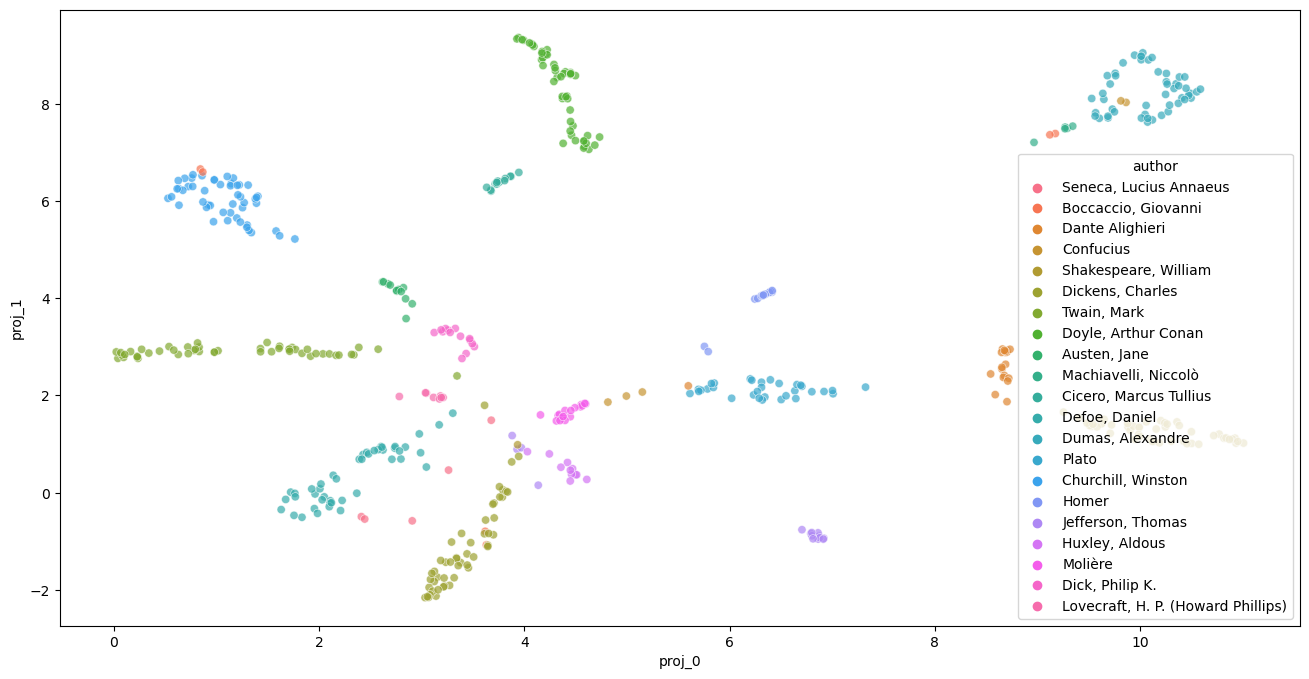

In [17]:
# # old code:
# sns.scatterplot(x=umap_projection[:,0], y=umap_projection[:,1], 
#                 hue = library_select.replace({'author': num_to_authors})['author'].astype('category'),
#                alpha = 0.7);

plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = 'author',
               alpha = 0.7);

In [18]:
library_select['authorcentury'].unique()

array([ 1., 14., 13., -6., 16., 19., 18., 15., -1., -4., 20., -7., 17.])

In [19]:
def annotate_century(num_century):

    if np.isnan(num_century):
        return 'unknown'
    elif int(num_century) < 0 :
        ctry = ' century BCE'
        num_century = abs(int(num_century))
    else:
        num_century = int(num_century)
        ctry = ' century CE'


    # determine ordinal numbering
    if (num_century % 10 == 1) and (num_century % 100 != 11):
        ordinal_century = str(num_century) + 'st'

    elif (num_century % 10 == 2) and (num_century % 100 != 12):
        ordinal_century = str(num_century) + 'nd'

    elif (num_century % 10 == 3) and (num_century % 100 != 13):
        ordinal_century = str(num_century) + 'rd'
        
    else:
        ordinal_century = str(num_century) + 'th'

    return ordinal_century + ctry

In [20]:
library_select['authorcentury'] = library_select['authorcentury'].apply(annotate_century)

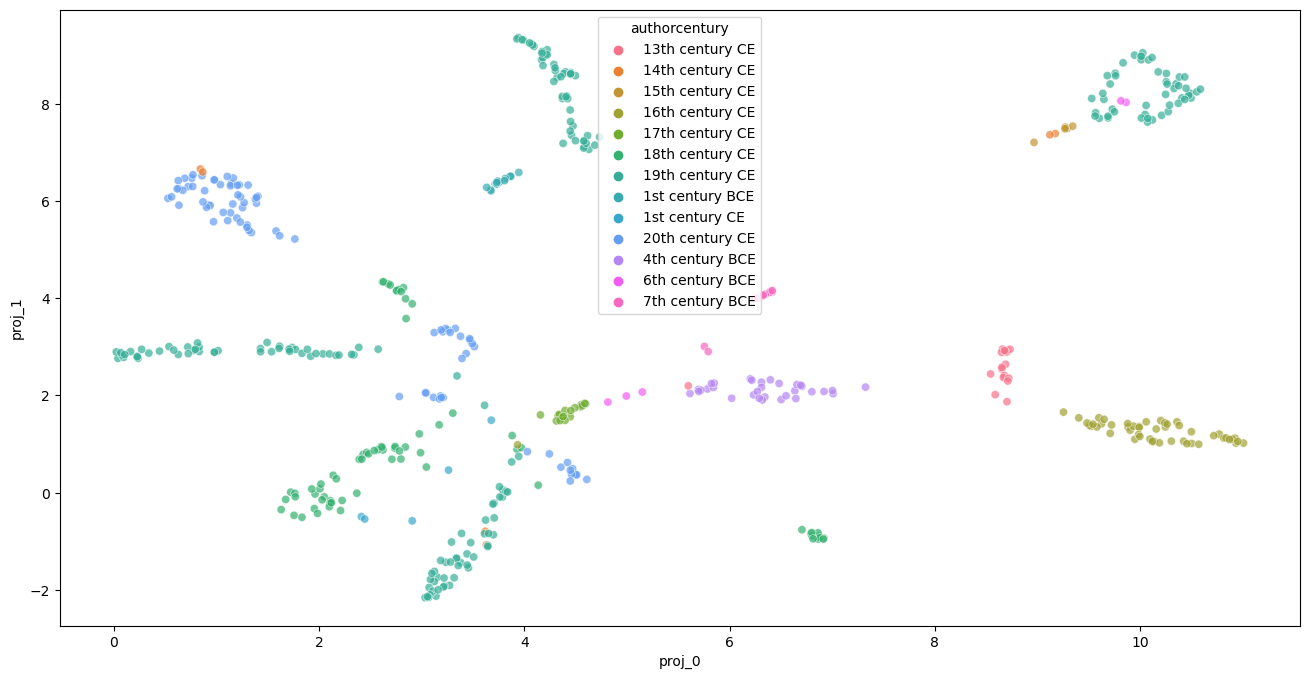

In [21]:
plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = library_select['authorcentury'].astype('category'),
               alpha = 0.7);

In [22]:
# make a copy -- personal note: important to use copy!! otherwise, it's just a view of the original dataframe 
# and that gives warnings in the following two parts
library_2d_dist = library_select[['author', 'proj_0', 'proj_1']].copy()

# calculate the mean point for each author
library_2d_dist[['proj_0_mean', 'proj_1_mean']] = library_2d_dist.groupby('author')[['proj_0', 'proj_1']].transform('mean')

# get the distance between each point and the mean for that author
library_2d_dist['dist_mean'] = np.sqrt((library_2d_dist['proj_0'] - library_2d_dist['proj_0_mean'])**2 + (library_2d_dist['proj_1'] - library_2d_dist['proj_1_mean'])**2)



In [23]:
library_2d_dist

,author,proj_0,proj_1,proj_0_mean,proj_1_mean,dist_mean
1,"Seneca, Lucius Annaeus",3.676631,1.491181,2.939734,0.067758,1.602856
6,"Boccaccio, Giovanni",9.173790,7.391255,4.541420,4.358118,5.537037
21,Dante Alighieri,8.543545,2.443485,8.510495,2.583077,0.143452
32,Dante Alighieri,8.689370,2.642284,8.510495,2.583077,0.188419
43,Dante Alighieri,8.653491,2.545713,8.510495,2.583077,0.147797
...,...,...,...,...,...,...
70047,"Dickens, Charles",3.278823,-1.428116,3.415447,-1.120742,0.336370
70069,"Dumas, Alexandre",10.074840,7.703770,10.076620,8.260368,0.556601
70091,"Dickens, Charles",3.355045,-1.501331,3.415447,-1.120742,0.385352
70102,"Dickens, Charles",3.442787,-1.490528,3.415447,-1.120742,0.370795


In [24]:
library_2d_dist['dist_mean'].describe()

count    527.000000
mean       0.620542
std        0.747931
min        0.007125
25%        0.239258
50%        0.457589
75%        0.733673
max        6.111665
Name: dist_mean, dtype: float64

In [25]:
dist2d_mean = library_2d_dist['dist_mean'].mean()

## Similarity using spatial distance in 100 dimension

Another way to look at the produced weights and which ones are similar

Calculating cosine similarity (using dim_0 to dim_99 cols) - for a first attempt, group it by author.

In [26]:
# idea use this to transpose and then see the dist from each book to this point?
library_select_grouped = library_select.drop(columns=['id','title','authorcentury','proj_0','proj_1']).groupby('author').mean()

In [27]:
dists = spatial.distance.pdist(library_select_grouped.values, metric='euclidean') # metric='cosine'

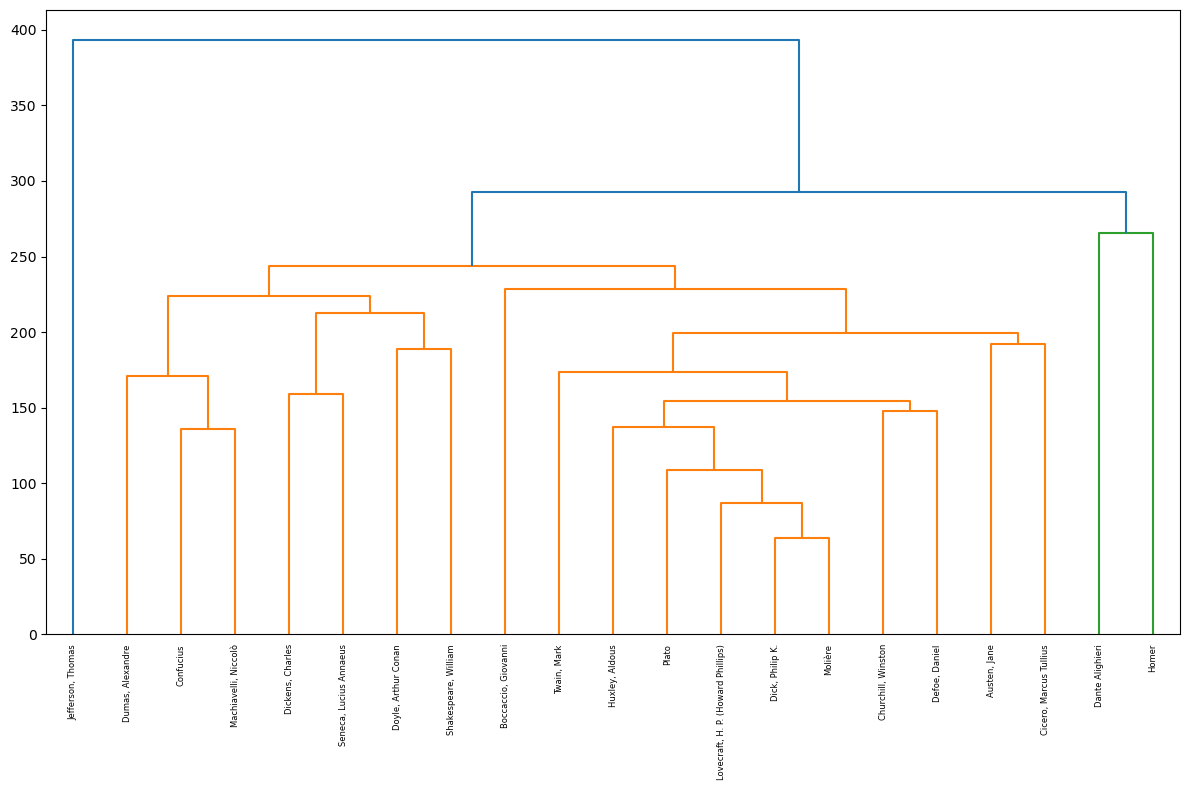

In [28]:
mergings = linkage(dists, method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(library_select_grouped.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()

In [29]:
# before I realized to use this approach, I first concatenated all the texts in the pandas series which returns an extremely long string
# I then turn that string into a pandas series (the predict requires an iterable object)
# pipe_nn.predict(pd.Series(library_select.loc[library_select['author'] == 0]['book_content'].str.cat()))

## Introducing New Text

This part will ideally be in an app where any text can be uploaded

Here I will test it with two books I've written.

In [30]:
# if the model was not run above, this is where we load the encoder and the umamp_mnist
# pipe_nn_encoder = load('../models/pipe_nn_encoder_02.joblib') 
# umap_mnist = load('../models/umap_mnist_02.joblib')

In [31]:
newtext = pd.DataFrame()

for book_num, book_name in enumerate(['Lambda', 'Deathway']):
        filepath = f'../data/{book_name} by Tomo Umer.txt'

        with open(filepath, encoding = 'utf-8') as fi:
                book = fi.read()
        
        tmp_text = pd.DataFrame({'id': f'TU{str(book_num).zfill(3)}',
                                 'title': [book_name],
                                 'author': 'Umer, Tomo',
                                 'authorcentury': 21,
                                 'book_content': [book]})

        newtext = pd.concat([newtext, tmp_text], ignore_index = True)

In [32]:
newtext

,id,title,author,authorcentury,book_content
0,TU000,Lambda,"Umer, Tomo",21,Lambda\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,TU001,Deathway,"Umer, Tomo",21,DeathwayIndex\nIntroduction\nMy second novel! ...


In [33]:
newtext['authorcentury'] = newtext['authorcentury'].apply(annotate_century)

As a reminder (to myself), in order to convert the new texts, we only need predict and transform methods

In [34]:
# now using predict from the encoder to get the 100-dimensional projection of new text
nn_represent_newtext = pipe_nn_encoder.predict(newtext['book_content'])

# and its 2d representation using umap
umap_projection_newtext = umap_mnist.transform(nn_represent_newtext)

In [35]:
# and then just like with the authors, convert new texts into a dataframe
# convert the 100 dimensional vector of neuron weights into dataframe
newtxt_represent = pd.DataFrame(nn_represent_newtext, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
newtxt_proj = pd.DataFrame(umap_projection_newtext, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
newtext = pd.concat([
    newtext[['id','title','author','authorcentury']],
    newtxt_proj.set_index(newtext.index),
    newtxt_represent.set_index(newtext.index)],
    axis=1)

Then, use the median 0.549409 (or possibly mean 0.721832) value to get a circle around the new texts - to visually represent similar books.

In [36]:
circle_edges = newtext[['proj_0', 'proj_1']].copy()

In [37]:
circle_edges['x0'] = circle_edges['proj_0'] - dist2d_mean
circle_edges['x1'] = circle_edges['proj_0'] + dist2d_mean
circle_edges['y0'] = circle_edges['proj_1'] - dist2d_mean
circle_edges['y1'] = circle_edges['proj_1'] + dist2d_mean

In [38]:
circle_edges

,proj_0,proj_1,x0,x1,y0,y1
0,1.842684,3.280559,1.222142,2.463225,2.660017,3.901101
1,2.394795,2.954535,1.774253,3.015337,2.333994,3.575077


Finally, simply add the new text to the library.

In [39]:
library_newtext = pd.concat([library_select, newtext])

In [40]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= 'author',
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

for i in range(circle_edges.shape[0]):
    fig.add_shape(type='circle',
        xref='x', yref='y',
        x0=circle_edges['x0'][i],
        y0=circle_edges['y0'][i],
        x1=circle_edges['x1'][i],
        y1=circle_edges['y1'][i],
        line_color='LightSeaGreen',
    )


fig.show()

In [41]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= library_newtext['authorcentury'].astype('category'),
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

fig.show()

In [42]:
dists = spatial.distance.pdist(library_newtext.drop(columns=['id', 'title', 'author', 'authorcentury', 'proj_0', 'proj_1']).values,  metric='euclidean') #metric = 'cosine'

In [43]:
np.mean(dists)

264.77692450088347

note: to find out the dist between two authors, need to get the correct index for dist.

for i < j < m (where m = num of authors):

index = m * i + j - ((i + 2) * (i + 1)) // 2

dists[index]

For Lambda, cosine distance:

In [44]:
m = library_newtext.shape[0]
j = m-2

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [45]:
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(10)

,title,author,Deathway
264,A Double Barrelled Detective Story,"Twain, Mark",71.874168
13,The Tragedy of Pudd'nhead Wilson,"Twain, Mark",74.182642
507,"Eve's Diary, Complete","Twain, Mark",78.975674
20,A Horse's Tale,"Twain, Mark",79.331002
284,"How to Tell a Story, and Other Essays","Twain, Mark",79.463037
16,Extract from Captain Stormfield's Visit to Heaven,"Twain, Mark",80.268807
494,"The Adventures of Tom Sawyer, Part 2.","Twain, Mark",80.477239
457,The Chimes: A Goblin Story of Some Bells That ...,"Dickens, Charles",82.459264
263,The American Claimant,"Twain, Mark",82.479927
272,1601: Conversation as it was by the Social Fir...,"Twain, Mark",82.557726


For Deathway, cosine distance:

In [46]:
m = library_newtext.shape[0]
j = m-1

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [47]:
# Lambda is of course the most similar ... if wanted, simply do a .drop(538) on all 3 dataframes
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(20)

,title,author,Deathway
272,1601: Conversation as it was by the Social Fir...,"Twain, Mark",48.649256
501,Hunted Down: The Detective Stories of Charles ...,"Dickens, Charles",49.590488
472,Mr. Keegan's Elopement,"Churchill, Winston",49.639188
507,"Eve's Diary, Complete","Twain, Mark",50.991000
266,The Facts Concerning the Recent Carnival of Cr...,"Twain, Mark",51.059313
519,To Be Read at Dusk,"Dickens, Charles",52.085753
143,"Extracts from Adam's Diary, translated from th...","Twain, Mark",52.533862
265,The Stolen White Elephant,"Twain, Mark",53.062147
493,"The Adventures of Tom Sawyer, Part 1.","Twain, Mark",53.341073
527,Lambda,"Umer, Tomo",53.352001
